In [108]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pdb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import requests as req

from imblearn.over_sampling import SMOTE
# import bokeh
# from bokeh.io import output_notebook, show
# from bokeh.resources import INLINE
# import bokeh.plotting as bp
# from bokeh.plotting import figure
#output_notebook(resources=INLINE)



mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = [20,15]
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] =15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['legend.fontsize'] = 15
pd.options.mode.chained_assignment = None


PLT_WIDTH_INCH = 20
PLT_HEIGHT_INCH = 15
plt.rcParams['figure.figsize'] = [PLT_WIDTH_INCH, PLT_HEIGHT_INCH]

%load_ext autoreload
%matplotlib inline



#task specific modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LOAD DATA

In [429]:
#features correlation
#all_features_from_spotify = pd.read_pickle('all_features_from_spotify_with_genres.dat')
#popular_songs = pd.read_pickle('final_popular_songs.dat')
#random_songs = pd.read_pickle('final_random_songs.dat')
all_songs = pd.read_pickle('fixed_all_songs.dat')
popular_songs = all_songs[all_songs['popular']==1]
unpopular_songs = all_songs[all_songs['popular']==0]

all_genres = list(pd.read_pickle('all_genres.dat')[0].values)
GENRES = list(pd.read_pickle('spotify_genres.dat')[0].values)

#fixed years
#fixed_years = pd.DataFrame(pd.read_csv('fixed_years.csv')['0'].reset_index(drop=True))

# FUNCTIONS

In [653]:
# %load spotify_client/spotify_client.py
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials


"""
we will get all the features from spotify, by song name and artist name.
this function will create a json file with all the data
"""
def get_song_features_and_info_json(song_name, artist_name):

    # getting credentials to request special API
    credenials = SpotifyClientCredentials(client_id="5659eaf41b194134866170761e2fb293",client_secret="17e2a9fa37c2466baa2ba05752896cdc")

    # getting the client
    spotify_client = spotipy.Spotify(client_credentials_manager=credenials)

    # getting the song id in order to retrieve features, limiting to 1 since it sorts the results by popularity
    song_results = spotify_client.search(q='artist:' + artist_name + ' track:' + song_name, type='track',limit=1)
    #print(song_results)
    tracks = song_results['tracks']['items']
    if len(tracks)==0:
        print("***no results for the requested track:{}***".format(song_name+":"+artist_name))
        return
    result_dict = tracks[0]

    # creating dict for track
    song_dict = creating_song_dictionary(artist_name, result_dict, spotify_client)

    return song_dict
def creating_song_dictionary(artist_name, result_dict, spotify_client):
    song_dict = {}
    song_dict['artist'] = artist_name
    song_id = [result_dict['uri']]
    song_dict['uri'] = song_id
    song_dict['year'] = result_dict['album']['release_date'][:4]
    song_dict['artist_id'] = result_dict['artists'][0]['id']
    song_dict['track_id'] = result_dict['id']
    song_dict['name'] = spotify_client.track(song_dict['track_id'])['name']
    song_dict['popularity'] = result_dict['popularity']
    song_dict['preview_link'] = result_dict['preview_url']
    features = spotify_client.audio_features(song_id)
    song_dict['main_features'] = features[0]

    # todo - need this? a big analysis, maybe will be helpful
    # analysis = spotify_client._get(features[0]['analysis_url'])
    #
    # song_dict['analysis'] = analysis

    return song_dict



SPOTIFY_COLUMNS = ['artist','artist_id','name','genre','decade','duration_ms','acousticness',
                  'danceability','energy','id','year',
                  'instrumentalness','liveness','loudness','speechiness','tempo','valence','popular']


selected_columns=['duration_ms',
                  'acousticness',
                  'danceability',
                  'energy',
                  'instrumentalness',
                  'liveness',
                  'loudness',
                  'speechiness',
                  'tempo',
                  'valence',
                  'genre_id']

def plot_statistics(df,column,group_by='decade'):
    clmns=['mean','std','min','max','25%','50%','75%']
    stats=df.groupby(group_by)[column].describe().T
    stats = stats.loc[clmns]
    ax=stats.plot(kind='box',title='{}'.format(column),figsize=(10,5),rot=90)
    ax.set_xlabel(group_by)
    
    
    
def get_artist_and_title(df):
    #return ["{}:{}".format(tup[0],tup[1]) for tup in list(zip(zz.loc['artist'].values,zz.loc['title'].values))]
    return list(zip(df.loc[:,'name'].values,df.loc[:,'artist'].values))



def scale_features(data):
    clmns = data.columns
    scaler = StandardScaler(with_mean=True)
    return pd.DataFrame(scaler.fit_transform(data),columns=clmns)



# getting credentials to request special API
credenials = SpotifyClientCredentials(client_id="5659eaf41b194134866170761e2fb293",client_secret="17e2a9fa37c2466baa2ba05752896cdc")

# getting the client
spotify_client = spotipy.Spotify(client_credentials_manager=credenials)

import re

def get_artist_genre(spotify_client,artist_id):
    artist_data = spotify_client.artist(artist_id)
    spotify_genres = artist_data["genres"]
    return spotify_genres

def get_number_of_apearence(genre,spotify_genres):
    count=0
    for spot_genre in spotify_genres:
        res = re.search(genre, spot_genre)
        if res:
            count+=1
    return count

def get_genres_scores_of_artist(spotify_client,artist_id):
    artist_genres=get_artist_genre(spotify_client,artist_id)
    return [get_number_of_apearence(genre,artist_genres) for genre in GENRES]

def get_genre_of_artist(spotify_client,artist_id):
    scores=get_genres_scores_of_artist(spotify_client,artist_id)
    if np.sum(scores)==0:
        return 'na'
    return GENRES[np.argmax(scores)]



def remove_dup_songs_from_random(all_songs_data_frame,subset):
    res=all_songs_data_frame.drop_duplicates(subset = subset,keep = 'first',inplace = False)
    return res


def get_year(artist,title):
    try:
        res=req.get('https://api.discogs.com/database/search?artist={0}&release_title={1}&per_page=10&page=1&token=AVfnfICgSgXIDXAWivYivedRIhMcDRvYCxrIshPk'.format(artist,title))
        return np.min([np.int(r['year']) for r in res.json()['results'] if 'year' in r.keys()]) 
    except Exception as e:
        #print(e)
        return None
    
def get_all_fixed_years(data):
    years=[]
    details=get_artist_and_title(data)
    for name,artist in details:
        year=get_year(artist,name)
        years.append(year)
        #print(year)
    return years

def extract_features_from_spotify(song_dict):
    new_song_dict={}
    for feature in SPOTIFY_COLUMNS:
        val = song_dict.get(feature,None) or song_dict['main_features'].get(feature)
        new_song_dict.update({feature:val})
    return pd.DataFrame(new_song_dict,index=[0])

def get_song(artist_name,song_name):
    song_features_dict=get_song_features_and_info_json(song_name=song_name,artist_name=artist_name)
    return spotify_preprocessing(song_features_dict)

Preprocessig

In [444]:
#df=pd.read_pickle('billboard.dat')

def cleaning_and_typing(df):    
    df.columns=np.arange(df.shape[1])
    df['num_words']=df['num_words'].astype(int)
    df['num_lines']=df['num_lines'].astype(int)
    df['num_dupes']=df['num_dupes'].astype(int)

    df['title'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    df['artist'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    return df
    
def create_decade_mappings():
    all_years=np.arange(1950,2016)
    decades=np.arange(1950,2016,10)
    decades_mappings={}
    cur_dec=decades[0]
    cur_dec_idx=0
    for year in all_years:
        if year%cur_dec>=10:
            cur_dec_idx+=1
            cur_dec=decades[cur_dec_idx]
        decades_mappings.update({year:cur_dec})
    return decades_mappings



def spotify_preprocessing(song_dict,is_popular=False):
    '''
        Parsing a *single* song from spotify
    '''
    #parse dict into df with SPOTIFY_COLUMNS
    df = extract_features_from_spotify(song_dict)
    
    #get year from discgo
    discgo_year=get_all_fixed_years(df)[0]
    
    #add decade
    df['year']=df['year'].astype(int)
    df['year'] = discgo_year or df['year']
    zz=df['year'].map(create_decade_mappings())
    zz=zz.fillna(1950)
    df.loc[:,'decade']=zz.astype(int)
    
    #clean artists
    df['name'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    df['artist'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    
    #add genre information for each song
    df.loc[:,'genre']=df['artist_id'].apply(lambda artist_id:get_genre_of_artist(spotify_client,artist_id))
    
    #add genre_id
    df.loc[:,'genre_id']=df['genre'].apply(lambda x: GENRES.index(x))
    
    #add popular column
    df.loc[:,'popular']=np.int(is_popular)
    
    #drop year column
    df = df.drop('year', 1)
    return df


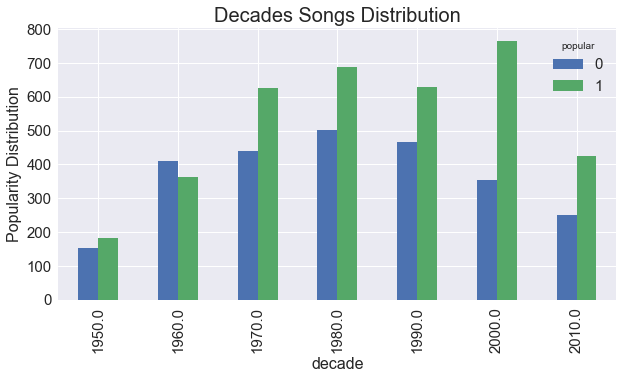

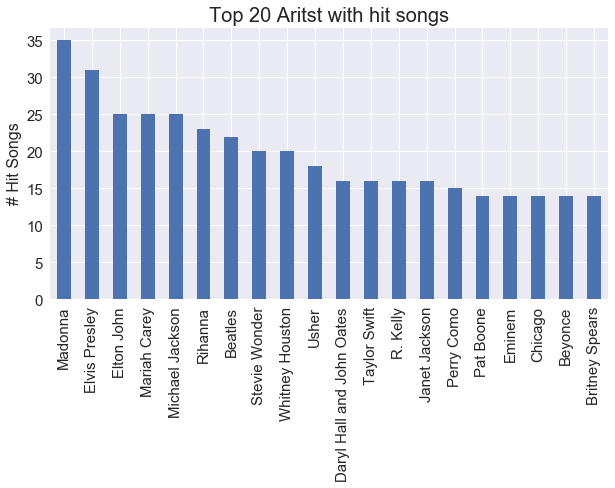

In [390]:
df=all_songs[all_songs['popular']==1]
plt.figure()
all_songs.groupby(['decade','popular']).count()['artist'].unstack().plot(kind='bar',figsize=(10,5),title='Decades Songs Distribution')
plt.ylabel('Popularity Distribution')

# df.groupby('decade').apply(lambda decade: len(decade)).plot(kind='bar',figsize=(10,5),title='Decades Popular Songs Distribution')
# plt.ylabel('# Hit Songs')


plt.figure()
top_art=20
df['artist'].value_counts().head(top_art).plot(kind='bar',figsize=(10,5),title='Top {} Aritst with hit songs'.format(top_art))
plt.ylabel('# Hit Songs')


#sns.factorplot(x='decade', y='', hue='sex', data=df, kind='bar')

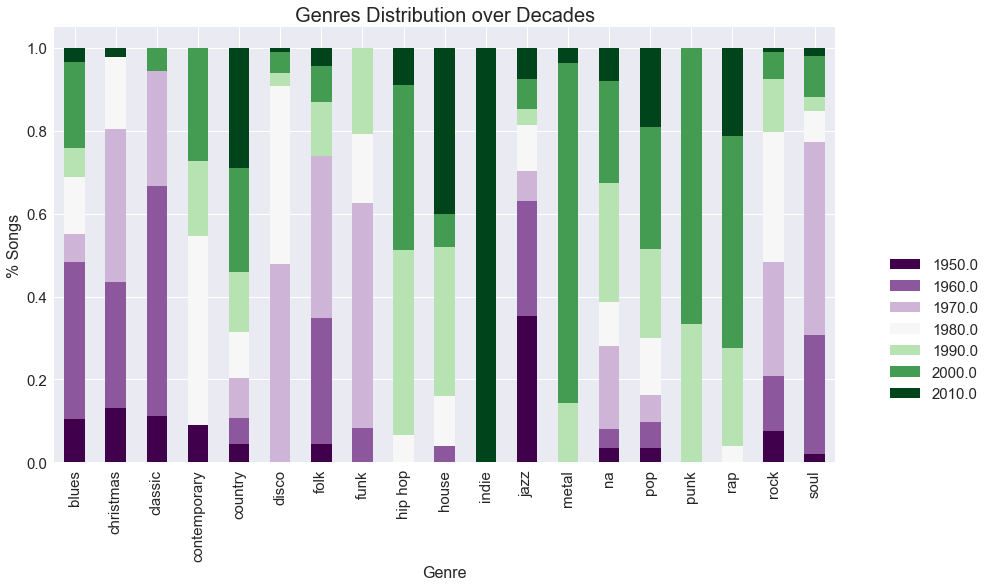

In [552]:
#genres dsitribution
def plot_genre_distribution(df):
    t=df.groupby(['genre','decade']).count()['artist'].unstack()
    sums=t.sum(axis=1).values
    t=t.div(sums,axis=0)
    ax=t.plot(kind='bar',stacked='True',figsize=(14,8),colormap='PRGn')
    ax.set_ylabel('% Songs')
    ax.set_xlabel('Genre')
    ax.set_title('Genres Distribution over Decades')
    ax.legend(bbox_to_anchor=(1.2, 0.5))

plot_genre_distribution(popular_songs)


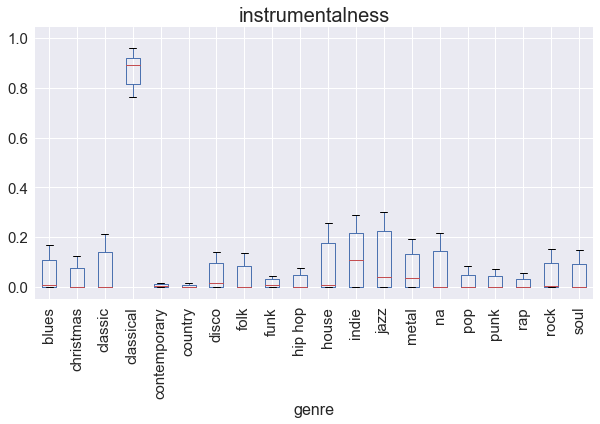

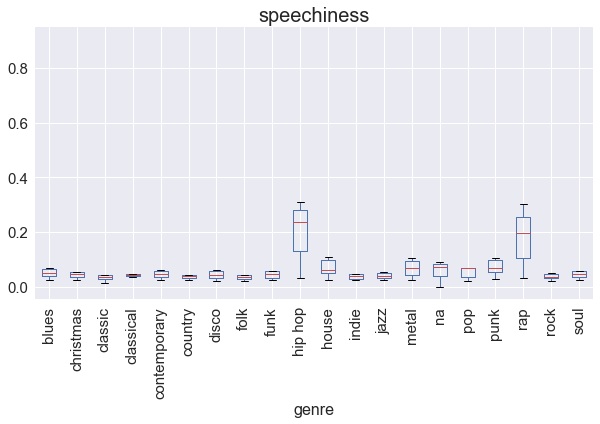

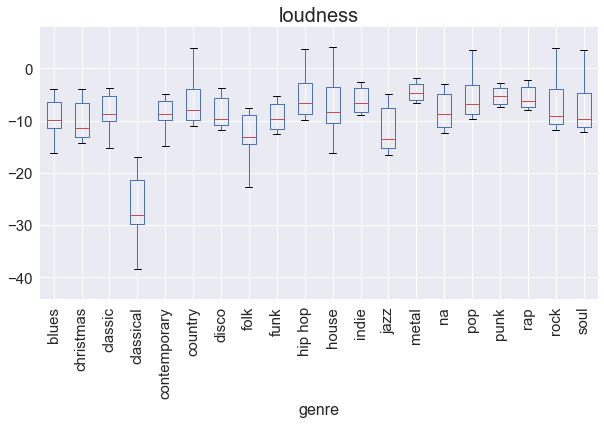

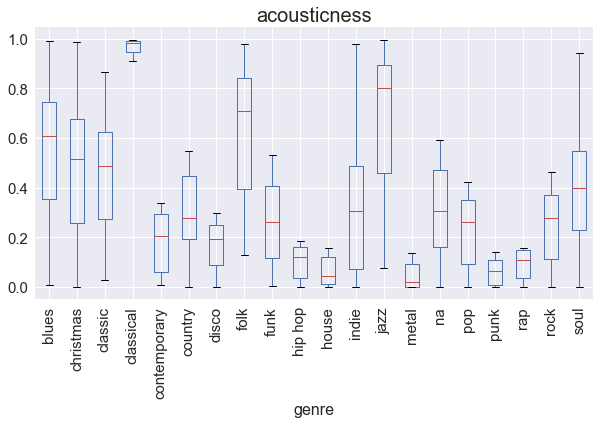

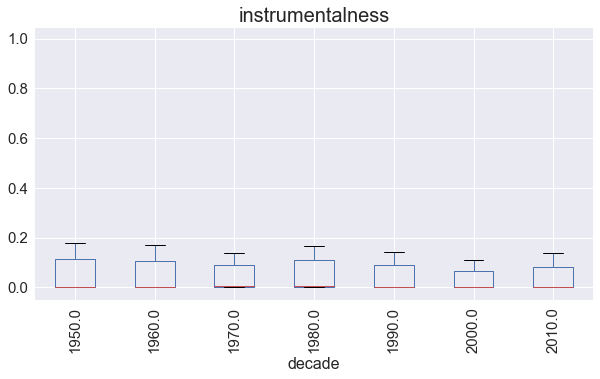

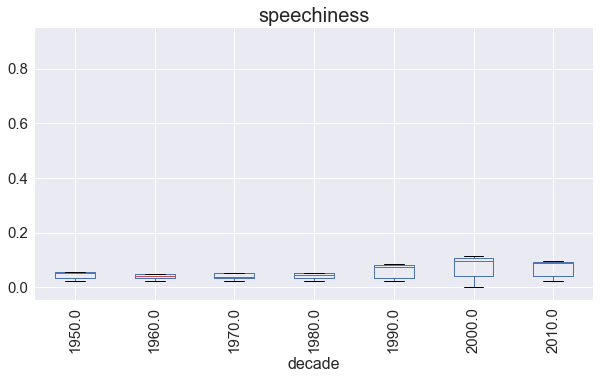

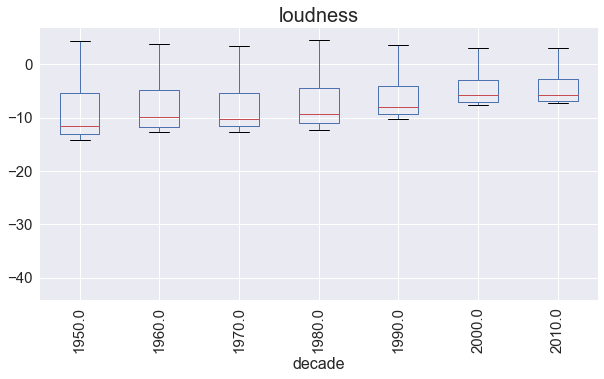

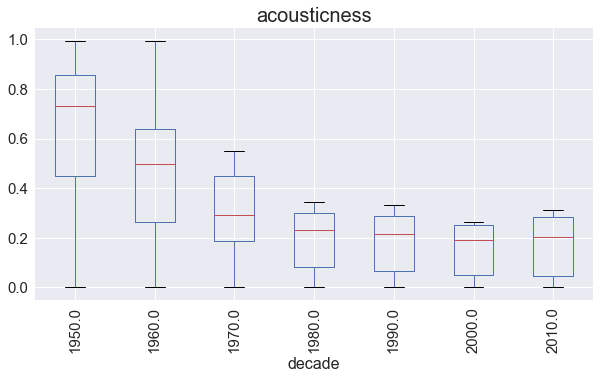

In [596]:
#plot different stats for each feature
clmns = ['instrumentalness','speechiness','loudness','acousticness']
for grouped in ['genre','decade']:
    for feature in clmns:
        plt.figure()
        plot_statistics(all_songs,feature,group_by=grouped)
    

In [597]:
#features correlation
all_songs[selected_columns].corr().style.background_gradient()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre_id
duration_ms,1,-0.202763,-0.0284096,0.0738931,0.111463,-0.0144781,0.00188375,0.0372911,-0.0215567,-0.198055,-0.0278668
acousticness,-0.202763,1,-0.279772,-0.673694,0.111786,-0.0249786,-0.519521,-0.16492,-0.118437,-0.228938,0.0733502
danceability,-0.0284096,-0.279772,1,0.198707,-0.135901,-0.0995975,0.191514,0.204167,-0.15584,0.509859,0.15936
energy,0.0738931,-0.673694,0.198707,1,-0.12071,0.135095,0.753603,0.166147,0.179222,0.38486,-0.088013
instrumentalness,0.111463,0.111786,-0.135901,-0.12071,1,-0.0197841,-0.281588,-0.048318,-0.024428,-0.130548,0.001814
liveness,-0.0144781,-0.0249786,-0.0995975,0.135095,-0.0197841,1,0.0786942,0.11615,0.0226399,0.0211519,0.0106835
loudness,0.00188375,-0.519521,0.191514,0.753603,-0.281588,0.0786942,1,0.149074,0.109716,0.192554,-0.0879705
speechiness,0.0372911,-0.16492,0.204167,0.166147,-0.048318,0.11615,0.149074,1,0.033669,0.0683381,0.164057
tempo,-0.0215567,-0.118437,-0.15584,0.179222,-0.024428,0.0226399,0.109716,0.033669,1,0.0896556,-0.0540499
valence,-0.198055,-0.228938,0.509859,0.38486,-0.130548,0.0211519,0.192554,0.0683381,0.0896556,1,0.0997472


c:\users\melgu_000\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:590: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
c:\users\melgu_000\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.5104273302745366


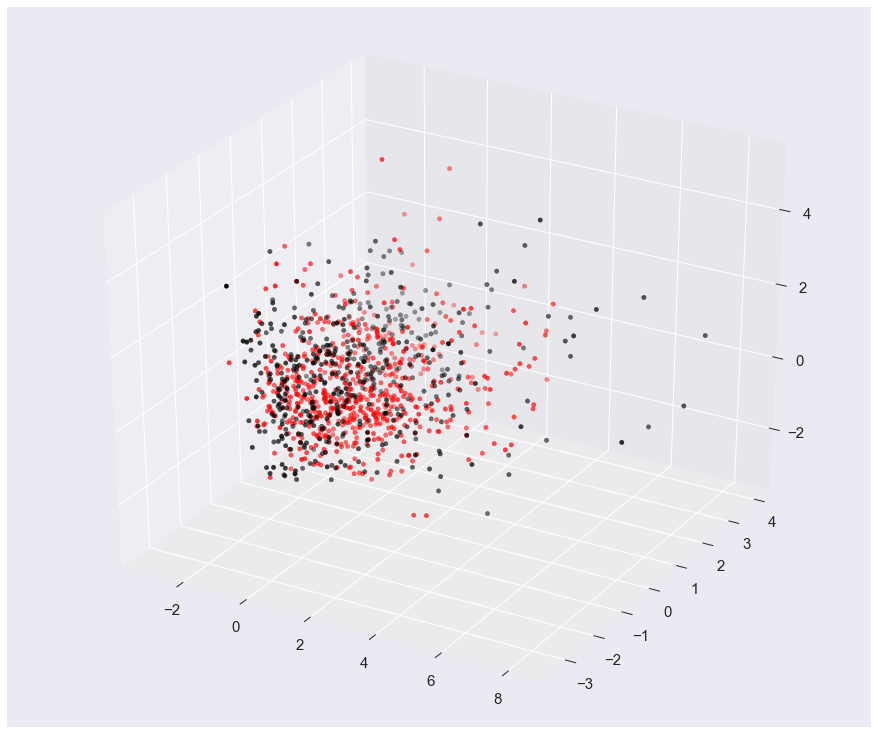

In [654]:
#PCA
from sklearn.decomposition import PCA
POPULARITY_COLORS = {0:'black',1:'red'}

# selected_columns=[
#                   'acousticness',
#                   'danceability',
#                   'energy',
#                   'instrumentalness',
#                   'speechiness']

def plot_pca_by_decade(df,decade=2000,N=3,colors='popular'):
    decade_data = df[df['decade']==decade]
    pca_data = decade_data[selected_columns]
    #make std=1 and mean=0
    pca_data = scale_features(pca_data)
    pca = PCA(n_components=N,svd_solver='full')
    pca.fit(pca_data)
    X_pca = pca.transform(pca_data)
    if colors == 'popular':
        clrs = [POPULARITY_COLORS[pop] for pop in decade_data['popular'].values]
    if colors == 'genre':
        rand_colors=np.random.rand(3,len(GENRES))
        clrs = [rand_colors[:,genre_idx] for genre_idx in decade_data['genre_id'].values]
        
    fig=plt.figure(figsize=(12, 10))
    if N==3:
        ax = Axes3D(fig)
        ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=clrs,s=20)
    else:
        plt.scatter(X_pca[:,0],X_pca[:,1],c=clrs)
    print(np.sum(pca.explained_variance_ratio_))
plot_pca_by_decade(all_songs,N=3,decade=1990,colors='popular')

In [12]:
#kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7)
kmeans_data=all_features_from_spotify[selected_columns]
kmeans.fit(kmeans_data)
labels = kmeans.predict(kmeans_data)



In [95]:
clrs={0:'r',1:'b',2:'g',3:'y',4:'magenta',5:'cyan',6:'brown'}
kmeans_clrs = [clrs[idx] for idx in labels]


In [96]:
clrs={1950:'r',1960:'b',1970:'g',1980:'y',1990:'magenta',2000:'cyan',2010:'brown'}
decade_clrs = [clrs[row[1]['decade']] for row in all_features_from_spotify.iterrows()]

In [97]:
rand_colors=np.random.rand(3,len(GENRES))
genres_clrs = [rand_colors[:,GENRES.index(row[1]['genre'])] for row in all_features_from_spotify.iterrows()]

In [16]:
selected_columns=['duration_ms','acousticness',
                  'danceability','energy',
                  'instrumentalness','liveness','loudness','speechiness','tempo','valence']

we can see we have expected correlation between energy and loudness, but nothing more.

## Get all genres from everynoise

In [27]:
# import requests
# from bs4 import BeautifulSoup
# url = 'http://everynoise.com/everynoise1d.cgi?scope=all'
# r = requests.get(url)
# html_content = r.text
# soup = BeautifulSoup(html_content, 'lxml')

# links=soup.find_all("a", {"title": "Re-sort the list starting from here."})
# all_genres=[link.text for link in links]



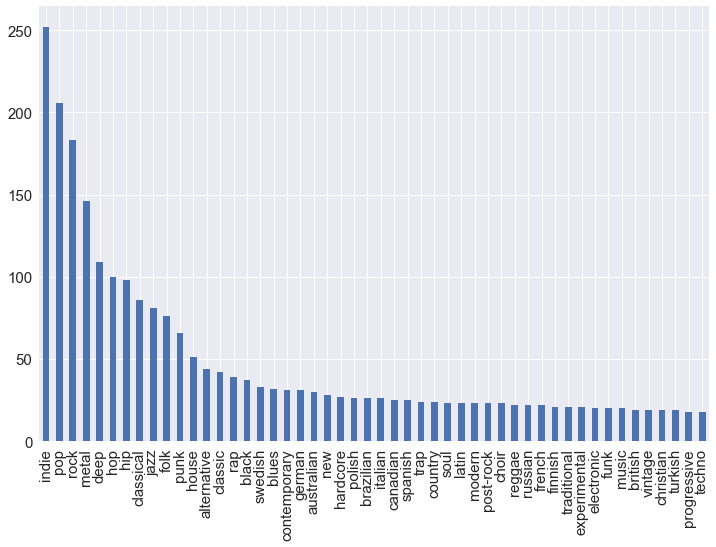

In [25]:
import itertools
splitted_genres=[gen.split() for gen in all_genres]

splitted_genres = list(itertools.chain(*splitted_genres))

pd.DataFrame(splitted_genres)[0].value_counts().head(50).plot(kind='bar',figsize=(12,8))

In [26]:
TOP_GENRES=20
GENRES=list(pd.DataFrame(splitted_genres)[0].value_counts().head(TOP_GENRES).keys())
#fix hip and hop
GENRES=[g for g in GENRES if g not in ['hip','hop']]
GENRES+=['country','christmas','disco','funk','soul','na','hip hop']
GENRES

['indie',
 'pop',
 'rock',
 'metal',
 'deep',
 'classical',
 'jazz',
 'folk',
 'punk',
 'house',
 'alternative',
 'classic',
 'rap',
 'black',
 'swedish',
 'blues',
 'contemporary',
 'german',
 'country',
 'christmas',
 'disco',
 'funk',
 'soul',
 'na',
 'hip hop']

In [240]:
# #add genre information for each song
# all_features_from_spotify['genre']=all_features_from_spotify['artist_id'].apply(lambda artist_id:get_genre_of_artist(spotify_client,artist_id))

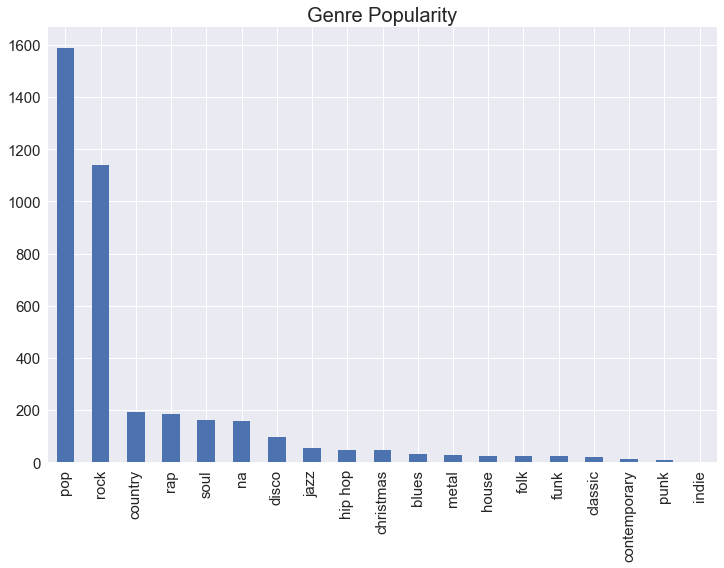

In [241]:
#genres distribution
all_features_from_spotify['genre'].value_counts().plot(kind='bar',title='Genre Popularity',figsize=(12,8))

In [79]:
def evaluate_models(features,labels,models,scoring_method='accuracy',CV=5):
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model,features, labels, scoring=scoring_method, cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', scoring_method])
    sns.boxplot(x='model_name', y=scoring_method, data=cv_df)
    sns.stripplot(x='model_name', y=scoring_method, data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.title('Scoring Method={}'.format(scoring_method))
    plt.xticks(rotation=45)
    a=plt.show()
    print(cv_df.groupby('model_name')[scoring_method].mean())
    return cv_df


def evaluate_model_stats(model,X_train, X_test, y_train, y_test,train=True):
    if train:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
   # sns.heatmap(conf_mat, annot=True, fmt='d',
                #xticklabels=AUTHOR_ID.keys(), yticklabels=AUTHOR_ID.keys())
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("{} Confusion Martix".format(model.__class__.__name__))

    print(metrics.classification_report(y_test, y_pred, target_names=['No-Popular','Popular']))

    #calculate log-loss
    print("{}:Log-Loss:{}".format(model.__class__.__name__,log_loss(y_test,y_pred_probs)))
    return model,y_pred,y_pred_probs,conf_mat




#accuracy_cv_df=evaluate_models(features,labels,models,scoring_method='accuracy')


#Using Neg-Log-Loss
models_2 = [
    MultinomialNB(),
    LogisticRegression(solver='sag',random_state=0)
]

#log_loss_cv_df = evaluate_models(features,labels,models_2,scoring_method='neg_log_loss')

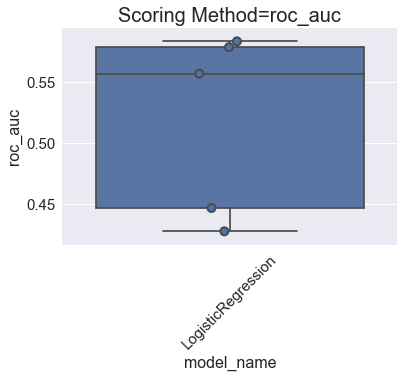

model_name
LogisticRegression    0.518764
Name: roc_auc, dtype: float64


In [103]:



#Using Accuracy
models = [
    #LinearSVC(),
    #MultinomialNB(),
    LogisticRegression(solver='sag',random_state=0),
]

accuracy_cv_df=evaluate_models(scaled_data,labels,models,scoring_method='roc_auc')

             precision    recall  f1-score   support

 No-Popular       0.80      0.06      0.11        71
    Popular       0.76      1.00      0.86       211

avg / total       0.77      0.76      0.67       282

LogisticRegression:Log-Loss:0.5369095805045476


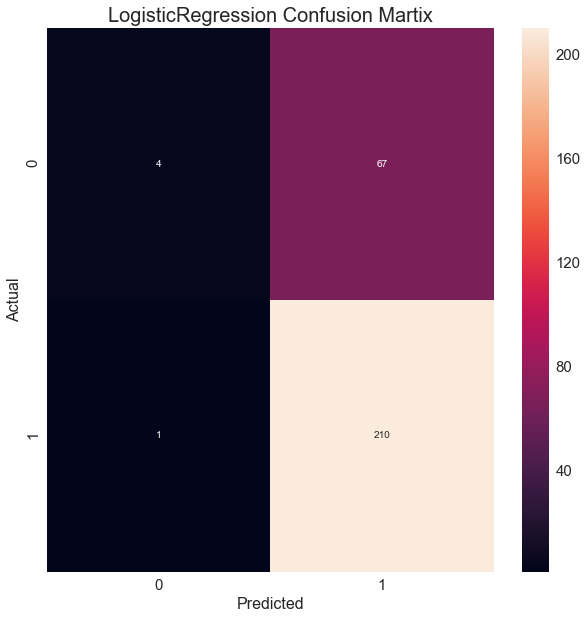

In [85]:
#split train/test the vectorized features
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(scaled_data, labels, scaled_data.index, test_size=0.20, random_state=0)




#Logit model
model = LogisticRegression(solver='sag',random_state=0)
z=evaluate_model_stats(model,X_train, X_test, y_train, y_test)

# #NB Model
# model = MultinomialNB()
# z=evaluate_model_stats(model,X_train, X_test, y_train, y_test)


In [ ]:
#first, we'll split to train/test the raw data itself
data_train, data_test, labels_train, labels_test, indices_train, indices_test = train_test_split(df, df[LABEL], df.index, test_size=0.20, random_state=0)


classifier = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True,stop_words='english',token_pattern=r'\w{2,}')),
                      ('clf', MultinomialNB()),
])

# parameter tuning with grid search
from sklearn.model_selection import GridSearchCV
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__max_features':(10000,30000,50000),
              'clf__alpha': (0.3, 0.5,1)
}
gs_clf = GridSearchCV(classifier, parameters)

In [365]:

# all_songs=all_songs.reset_index(drop=True)

# fixed_years[fixed_years<1950]=1950

# fixed_decades=fixed_years['0'].map(create_decade_mappings())


# missing_decades = all_songs[fixed_decades.isnull().values]['decade']

# fixed_decades[fixed_decades.isnull().values]=missing_decades.values

# all_songs['decade']=fixed_decades.values


# all_songs.to_pickle('fixed_all_songs.dat')